<a href="https://colab.research.google.com/github/Skeo220/time-series-deep-learning-EUR-USD/blob/main/EUR_USD_Model_Evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import yfinance as yf
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [ ]:
# setting the currency pair
forex_pair = 'EURUSD=X'
# downloading the data
data = yf.download(forex_pair, period='max')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
cols_to_drop = ['Adj Close', 'Volume']
data = data.drop(cols_to_drop, axis=1)
data = data.reset_index()
data.tail()

,Date,Open,High,Low,Close
5161,2023-10-23,1.058997,1.064736,1.057183,1.058997
5162,2023-10-24,1.066985,1.069050,1.058425,1.066985
5163,2023-10-25,1.059535,1.060670,1.056680,1.059535
5164,2023-10-26,1.056725,1.056971,1.052632,1.056725
5165,2023-10-27,1.056412,1.059996,1.053852,1.056859


In [ ]:
model_df = data.iloc[:-10]
eval_df = data.iloc[-10:]
print(data.shape, model_df.shape, eval_df.shape)

(5166, 5) (5156, 5) (10, 5)


# Data Preprocessing and Feature Engineering

In [ ]:
def preprocess(df):
  # transforming the date index
  df['Date'] = pd.to_datetime(df['Date'])
  df['day_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 5)
  df['day_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 5)
  df = df.drop('Date', axis = 1)
  df = df.dropna()
  df.describe().transpose()

  return df

In [ ]:
model_df = preprocess(model_df)

## Splitting the dataset

In [ ]:
def split_data(df):
    n = len(df)
    # Split 90:5:5 (train:validation:test)
    train_df = df[0:int(n*0.9)].reset_index(drop=True)
    val_df = df[int(n*0.9):int(n*0.95)].reset_index(drop=True)
    test_df = df[int(n*0.95):].reset_index(drop=True)

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = split_data(model_df)

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(4640, 6) (258, 6) (258, 6)


## Scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [ ]:
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [ ]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

## Model Preparations

In [ ]:
# implimenting Datawindow()
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (d)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
# implementing a multistep model
multi_window = DataWindow(input_width=10, label_width=10, shift=10,
                          label_columns=['Close'])

# Model Building

In [ ]:
# Define hyperparameter combinations to explore for LSTM layers
lstm_layers = [2,3]  # Number of LSTM layers
lstm_layer_sizes = [32, 64, 128]  # Number of neurons in each LSTM layer

lstm_combinations = list(itertools.product(lstm_layers, lstm_layer_sizes))

# Create dictionaries to store results
lstm_results = {'combination': [], 'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [], 'test_mae':[], 'aic': [], 'bic': []}

# Initialize variables to track the best LSTM model
best_lstm_combo = None
best_lstm_aic = float('inf')  # Initialize with a high value

# Loop through LSTM hyperparameter combinations
for lstm_combo in lstm_combinations:
    num_lstm_layers, lstm_layer_size = lstm_combo

    # Create a sequential model
    lstm_model = Sequential()

    # Add the specified number of LSTM layers with the same number of neurons
    for _ in range(num_lstm_layers):
        lstm_model.add(LSTM(lstm_layer_size, return_sequences=True))

    # Add a Dense output layer
    lstm_model.add(Dense(1, kernel_initializer=tf.initializers.zeros))

    # Compile and fit the LSTM model
    lstm_history = compile_and_fit(lstm_model, multi_window)

    # Calculate AIC and BIC
    n = len(multi_window.train_df)
    k = len(lstm_model.trainable_variables)
    train_mae = lstm_model.evaluate(multi_window.train)[1]
    val_mae = lstm_model.evaluate(multi_window.val)[1]
    test_mae = lstm_model.evaluate(multi_window.test)[1]
    train_loss = lstm_history.history['loss'][-1]
    val_loss = lstm_history.history['val_loss'][-1]
    aic = n * np.log(train_loss) + 2 * k
    bic = n * np.log(train_loss) + k * np.log(n)

    # Store LSTM results
    lstm_results['combination'].append(lstm_combo)
    lstm_results['train_loss'].append(train_loss)
    lstm_results['val_loss'].append(val_loss)
    lstm_results['train_mae'].append(train_mae)
    lstm_results['val_mae'].append(val_mae)
    lstm_results['test_mae'].append(test_mae)
    lstm_results['aic'].append(aic)
    lstm_results['bic'].append(bic)

    # Check if this LSTM model has a lower AIC, indicating it's better
    if aic < best_lstm_aic:
        best_lstm_aic = aic
        best_lstm_combo = lstm_combo

# Convert LSTM results to a DataFrame for easy analysis
import pandas as pd
lstm_results_df = pd.DataFrame(lstm_results)

# Sort LSTM results by AIC or BIC, or any other metric you want to use for model selection
sorted_lstm_results = lstm_results_df.sort_values(by='test_mae', ascending=False)

# Display the best LSTM model based on AIC or BIC
best_lstm_model = sorted_lstm_results.iloc[0]
print("Best LSTM Model (based on test_mae):", best_lstm_model)

# Create a separate DataFrame for the best LSTM model combo
best_lstm_combo_df = pd.DataFrame({
    'combination': [best_lstm_combo],
    'train_loss': [best_lstm_model['train_loss']],
    'val_loss': [best_lstm_model['val_loss']],
    'train_mae': [best_lstm_model['train_mae']],
    'val_mae': [best_lstm_model['val_mae']],
    'test_mae': [best_lstm_model['test_mae']],
    'aic': [best_lstm_model['aic']],
    'bic': [best_lstm_model['bic']]
})

print("Best LSTM Model Combo:", best_lstm_combo_df)

Epoch 1/50
145/145 [==============================] - 15s 37ms/step - loss: 0.0493 - mean_absolute_error: 0.1544 - val_loss: 0.0087 - val_mean_absolute_error: 0.0761
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0068 - mean_absolute_error: 0.0547 - val_loss: 0.0052 - val_mean_absolute_error: 0.0542
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_absolute_error: 0.0398 - val_loss: 0.0042 - val_mean_absolute_error: 0.0498
Epoch 4/50
145/145 [==============================] - 2s 15ms/step - loss: 0.0022 - mean_absolute_error: 0.0354 - val_loss: 0.0028 - val_mean_absolute_error: 0.0396
Epoch 5/50
145/145 [==============================] - 2s 15ms/step - loss: 0.0020 - mean_absolute_error: 0.0336 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375
Epoch 6/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - val_loss: 0.0023 - val_mean_absolute_error: 0.0363
Epoch 7/5

In [ ]:
train_performance = {}
val_performance = {}
test_performance = {}

In [ ]:
# Use the best LSTM model from the previous code
best_lstm_model = Sequential()

# Add the number of LSTM layers and neurons from the best LSTM combo
num_lstm_layers, lstm_layer_size = best_lstm_combo
for _ in range(num_lstm_layers):
    best_lstm_model.add(LSTM(lstm_layer_size, return_sequences=True))

# Add a Dense output layer
best_lstm_model.add(Dense(1, kernel_initializer=tf.initializers.zeros))

# Compile and fit the best LSTM model
lstm_history = compile_and_fit(best_lstm_model, multi_window)

# Evaluate the best model on the train set
train_performance['best_lstm_model'] = best_lstm_model.evaluate(multi_window.train)

# Evaluate the best model on the validation set
val_performance['best_lstm_model'] = best_lstm_model.evaluate(multi_window.val)

# Evaluate the best model on the test set
test_performance['best_lstm_model'] = best_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
145/145 [==============================] - 17s 68ms/step - loss: 0.0344 - mean_absolute_error: 0.1187 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517
Epoch 2/50
145/145 [==============================] - 7s 50ms/step - loss: 0.0024 - mean_absolute_error: 0.0364 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354
Epoch 3/50
145/145 [==============================] - 8s 57ms/step - loss: 0.0021 - mean_absolute_error: 0.0336 - val_loss: 0.0021 - val_mean_absolute_error: 0.0347
Epoch 4/50
145/145 [==============================] - 8s 57ms/step - loss: 0.0021 - mean_absolute_error: 0.0334 - val_loss: 0.0020 - val_mean_absolute_error: 0.0340
Epoch 5/50
145/145 [==============================] - 8s 53ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 6/50
145/145 [==============================] - 7s 48ms/step - loss: 0.0020 - mean_absolute_error: 0.0328 - val_loss: 0.0015 - val_mean_absolute_error: 0.0294
Epoch 7/5

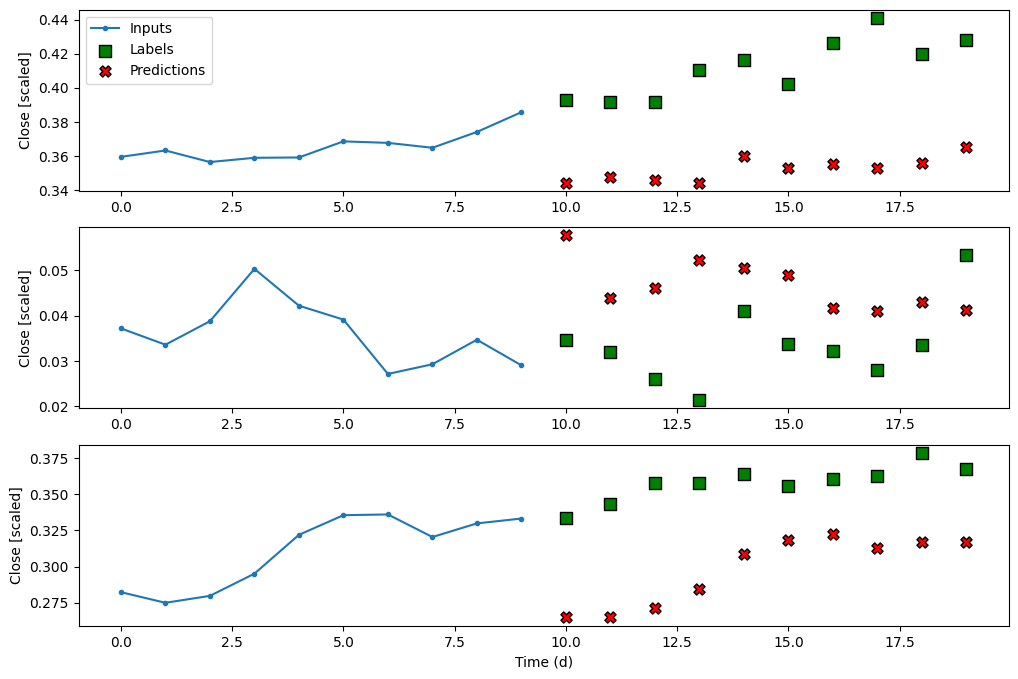

In [ ]:
# Plot the performance of the best LSTM model
multi_window.plot(best_lstm_model)

In [ ]:
best_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 128)           69120     
                                                                 
 lstm_16 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_17 (LSTM)              (None, 10, 128)           131584    
                                                                 
 dense_6 (Dense)             (None, 10, 1)             129       
                                                                 
Total params: 332417 (1.27 MB)
Trainable params: 332417 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Evaluation

In [ ]:
historical_data = data[-20:-10]
historical_data = preprocess(historical_data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
new_scaler = MinMaxScaler()
new_scaler.fit(historical_data)

MinMaxScaler()

In [ ]:
# Historical data including the 10 days leading up to the out of time period
historical_data = data[-20:-10]
historical_data = preprocess(historical_data)
historical_data[historical_data.columns] = scaler.transform(historical_data[historical_data.columns])

In [ ]:
historical_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,10.0,0.027647,0.008993,0.014025,2.157496e-02,0.028992,0.032587,0.041223
High,10.0,0.028183,0.008464,0.013259,2.181654e-02,0.029202,0.034641,0.039079
Low,10.0,0.645779,0.002987,0.641852,6.442466e-01,0.645064,0.647792,0.651287
Close,10.0,0.028217,0.008978,0.014618,2.215539e-02,0.029560,0.033149,0.041770
day_sin,10.0,0.500000,0.391857,0.000000,1.909830e-01,0.500000,0.809017,1.000000
day_cos,10.0,0.447214,0.412023,0.000000,1.110223e-16,0.618034,0.618034,1.000000


In [ ]:
# Use the best LSTM model to predict the next 10 days
input_sequence = historical_data
next_10_days_predictions = best_lstm_model.predict(np.array([input_sequence]))

1/1 [==============================] - 1s 1s/step


In [ ]:
# Reshape the predictions into a 1D array
next_10_days_predictions = next_10_days_predictions.reshape(-1, 1)

# Create a DataFrame with the 'Close' values
next_10_days_predictions = pd.DataFrame(next_10_days_predictions, columns=['Close'])

# Add 'day_sin' and 'day_cos' values (repeated for this example)
next_10_days_predictions['day_sin'] = [-0.587785, -0.951057, 0.000000, 0.951057, 0.587785] * 2
next_10_days_predictions['day_cos'] = [-0.809017, 0.309017, 1.000000, 0.309017, -0.809017] * 2

# Fill other columns with NaN (or provide the actual values)
next_10_days_predictions['Open'] = np.nan
next_10_days_predictions['High'] = np.nan
next_10_days_predictions['Low'] = np.nan

In [ ]:
# Inverse transform the scaled data
next_10_days_predictions[next_10_days_predictions.columns] = scaler.inverse_transform(next_10_days_predictions[next_10_days_predictions.columns])

In [ ]:
# Assign the 'Close' values to a column in eval_df
eval_df['pred_close'] = next_10_days_predictions['Close'].values

# Display eval_df
eval_df

,Date,Open,High,Low,Close,pred_close
5156,2023-10-16,1.052155,1.055465,1.051635,1.052155,1.069471
5157,2023-10-17,1.055431,1.059500,1.053341,1.055431,1.057440
5158,2023-10-18,1.057306,1.059547,1.052709,1.057306,1.055449
5159,2023-10-19,1.053852,1.058537,1.052886,1.053852,1.056890
5160,2023-10-20,1.058649,1.060108,1.056580,1.058649,1.060256
5161,2023-10-23,1.058997,1.064736,1.057183,1.058997,1.061857
5162,2023-10-24,1.066985,1.069050,1.058425,1.066985,1.063954
5163,2023-10-25,1.059535,1.060670,1.056680,1.059535,1.065513
5164,2023-10-26,1.056725,1.056971,1.052632,1.056725,1.066450
5165,2023-10-27,1.056412,1.059996,1.053852,1.056859,1.061386


In [ ]:
close_values = eval_df['Close']
pred_close_values = eval_df['pred_close']

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(np.abs(close_values - pred_close_values))

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.00519478202526078


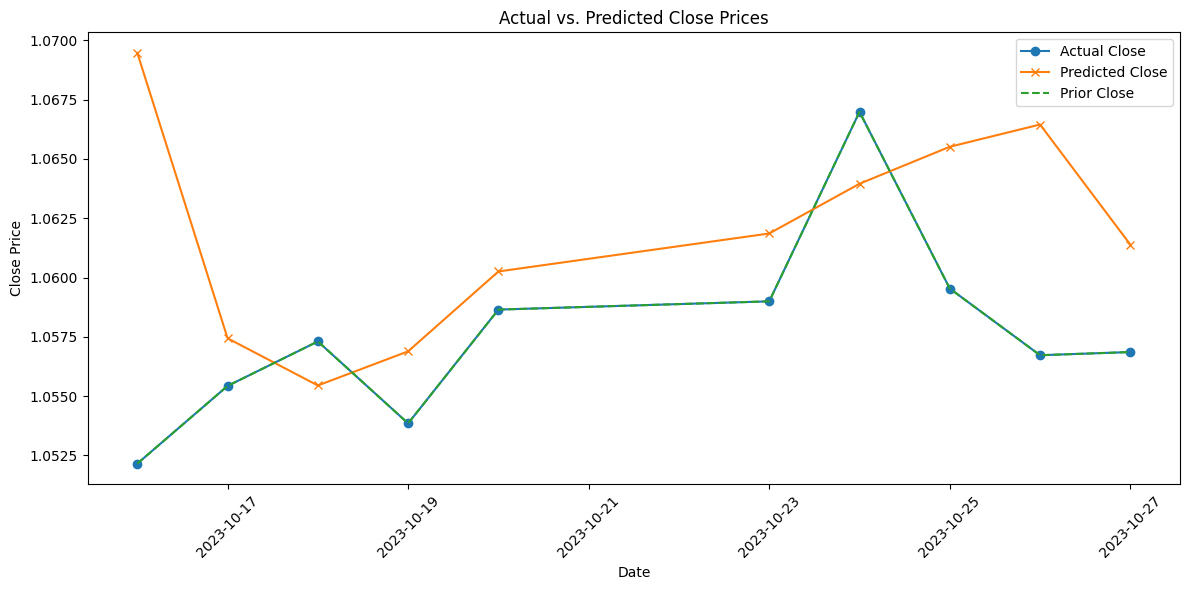

In [ ]:
# Assuming you have 'eval_df' DataFrame with 'Date', 'Close', and 'pred_close' columns
dates = eval_df['Date']
actual_close = eval_df['Close']
predicted_close = eval_df['pred_close']

# Create a figure and plot the data
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_close, label='Actual Close', marker='o')
plt.plot(dates, predicted_close, label='Predicted Close', marker='x')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Prices')

# Include prior 10 days from 'data' as well
prior_dates = data.iloc[-10:]['Date']
prior_actual_close = data.iloc[-10:]['Close']
plt.plot(prior_dates, prior_actual_close, label='Prior Close', linestyle='--')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the graph with a legend
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a new DataFrame with the last 20 days of data from data['Close']
last_20_days_data = data.iloc[-20:]

# Create a copy of the last 20 days of data as the original data
original_last_20_days_data = last_20_days_data.copy()

# Replace the last 10 values in the 'Close' column of last_20_days_data with the 'pred_close' values from eval_df
last_20_days_data['Close'][-10:] = eval_df['pred_close'].values

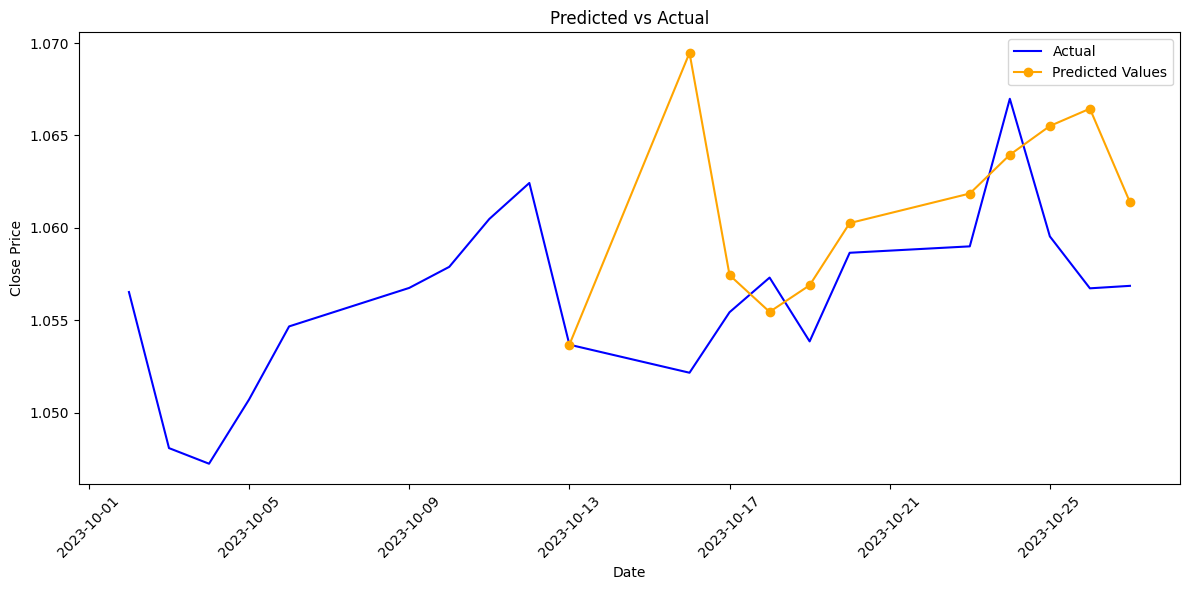

In [ ]:
# Create a figure and plot the data
plt.figure(figsize=(12, 6))

# Plot the original last 20 days of data
original_dates = original_last_20_days_data['Date']
original_close_values = original_last_20_days_data['Close']
plt.plot(original_dates, original_close_values, label='Actual', linestyle='-', color='blue')

# Plot only the last 11 values of the predicted data in orange
dates = last_20_days_data['Date']
close_values = last_20_days_data['Close'][-11:]
plt.plot(dates[-11:], close_values, label='Predicted Values', marker='o', color='orange')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted vs Actual')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the graph with a legend
plt.legend()
plt.tight_layout()
plt.show()